# Analyzing Sentiment in Amazon Product Reviews

https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

https://towardsdatascience.com/fine-grained-sentiment-analysis-part-3-fine-tuning-transformers-1ae6574f25a6

https://medium.com/analytics-vidhya/bert-using-hugging-face-for-sentiment-extraction-with-pytorch-2477980e7976

In [1]:
import os
import glob
import json
import gzip
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch

import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

### Stata by Category as DataFrame

In [2]:
# data_dir = "data/amazon/by_category_stata"

# li = []
# for filename in tqdm(glob.glob(data_dir + "/*")):
#     df = pd.read_stata(filename)
#     li.append(df)

# df = pd.concat(li, axis=0, ignore_index=True)
# df 

### Stata by Category as Loaders

In [3]:
# data_dir = "data/amazon/by_category_stata"
# train_loaders = {}
# batch_size = 100
# for json_file in tqdm(glob.glob(data_dir + "/*")):
#     category = os.path.basename(json_file).replace('.json.gz', '')
#     train_loaders[category] = pd.read_stata(json_file, chunksize=batch_size)
    
# train_loaders

### JSON by Category as Loaders

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

In [4]:
# data_dir = "data/amazon/by_category/raw"
# train_loaders = {}
# batch_size = 100
# for json_file in tqdm(glob.glob(data_dir + "/*")):
#     category = os.path.basename(json_file).replace('.json.gz', '')
#     train_loaders[category] = pd.read_json(json_file, lines=True, chunksize=batch_size)
    
# # train_loaders

# DataLoader

In [5]:
def load_data(data_dir, batch_size, keyword=""):
    train_loaders = {}
    for json_file in tqdm(glob.glob(data_dir + "/*" + keyword + "*")):
        category = os.path.basename(json_file).split(".", 1)[0] # keep only filename, no extensions
        train_loaders[category] = pd.read_json(os.path.abspath(json_file), lines=True, chunksize=batch_size)
    return train_loaders
# train_loaders

In [6]:
train_loaders = load_data("data/amazon/by_category/raw", batch_size=25)

### Adding derived columns

In [7]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [8]:
def preprocess_df(df):
    # remove unnecessary columns
    df = df.drop(columns=[
        'verified',
        'reviewTime',
        'reviewerID',
        'asin',
        'reviewerName',
        'unixReviewTime',
        'vote',
        'style',
        'image'
    ], errors='ignore')
    
    # create an approximate label from the star ratings for future training
    df['star_sentiment'] = df['overall'].apply(to_sentiment)
    
    # add the number of words in the reviewText
    df['num_words'] = df['reviewText'].str.split().str.len()
    
    # avoid possible data leakage where the thing to predict exists in the data
    df['summary'] = df['summary'].replace(['One Star', 
                                           'Two Stars', 
                                           'Three Stars', 
                                           'Four Stars', 
                                           'Five Stars'], '')
    
    columns = ['overall', 'star_sentiment', 'num_words', 'reviewText', 'summary']
    df = df[columns]
    
    return df

### Saving the preprocessed datasets back to the JSON original JSON format

In [9]:
def append_df_to_JSON(file, df):
    json_df = df.to_json(
        # path_or_buf=file_path,
        orient='records',
        lines=True
    )
    with open(file, 'a', encoding='utf8') as f:
        f.write(json_df)
        f.write("\n")

In [10]:
# save_path = "data/amazon/by_category/preprocessed"
# for file_name, json_loader in tqdm(train_loaders.items()):
#     print('preprocessing', file_name)
#     file_path = os.path.join(save_path, file_name + '.json')
#     for df in tqdm(json_loader):
#         df = preprocess_df(df)
#         append_df_to_JSON(file_path, df)

# Sentiment Pipeline

In [11]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

In [12]:
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"

# Previously tried ######################
# "roberta-base"                                                   | not sentiment analysis
# "roberta-large-mnli"                                             | not sentiment analysis
# "distilbert-base-uncased-finetuned-sst-2-english"                | works!!! NEGATIVE, POSITIVE
# "sshleifer/tiny-distilbert-base-uncased-finetuned-sst-2-english" | fail
# "textattack/roberta-base-SST-2"                                  | works!!! LABEL_0, LABEL_1
# "distilbert-base-uncased"                                        | fail
# "distilbert-base-cased"                                          | fail

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

In [14]:
classifier = pipeline(
    task='sentiment-analysis',
    model=model, 
    tokenizer=tokenizer,
    device=-1,
    framework='pt',
    return_all_scores=False
)

In [15]:
# classifier.model

In [16]:
# classifier('what is the time?')

In [ ]:
save_path = "data/amazon/by_category/preprocessed"

column_order = ['category_id', 
                'overall', 
                'star_sentiment', 
                'reviewText', 
                'summary', 
                'num_words', 
                'polarity']

category_id = 0

error_counter = 0

for file_name, json_loader in tqdm(train_loaders.items()):
    print('running sentiment-analysis on', file_name)
    file_path = os.path.join(save_path, file_name + '_results2.json')
    for df in tqdm(json_loader):
        
        # Preprocess #####################

        # create an approximate label from the star ratings for future training
        df['star_sentiment'] = df['overall'].apply(to_sentiment)

        # add the number of words in the reviewText
        df['num_words'] = df['reviewText'].str.split().str.len()

        # avoid possible data leakage where the thing to predict exists in the data
        df['summary'] = df['summary'].replace(['One Star', 
                                               'Two Stars', 
                                               'Three Stars', 
                                               'Four Stars', 
                                               'Five Stars'], '')
        
        # add category_id
        df['category_id'] = category_id
        
        # drop irrelevant columns
        df = df.drop(columns=[
            'verified',
            'reviewTime',
            'reviewerID',
            'asin',
            'reviewerName',
            'unixReviewTime',
            'vote',
            'style',
            'image'
        ], errors='ignore')

        # Sentiment Analysis ##################### 
        try:
            sentiments = classifier(list(df['reviewText']))
        except:
            error_counter+=1
            continue
            
        df_results = pd.DataFrame(sentiments)
        
        df['polarity'] = np.where(df_results['label'] == 'POSITIVE', 
                                  df_results['score'], 
                                  df_results['score'] * -1)
        
        df = df[column_order]
        
        # Save results #####################
        append_df_to_JSON(file_path, df)
    
    print(error_counter)
    category_id += 1

running sentiment-analysis on All_Beauty



1484
running sentiment-analysis on AMAZON_FASHION


# Reviewing Results

In [67]:
results_dir = "data/amazon/by_category/preprocessed"
results_loaders = load_data(results_dir, batch_size=25, keyword="results2")
results_loaders

{'All_Beauty_results2': <pandas.io.json._json.JsonReader at 0x1f8f328ec10>,
 'AMAZON_FASHION_results2': <pandas.io.json._json.JsonReader at 0x1f8f328e400>}

In [68]:
# intervals for binning the polarity
cut_class = np.arange(3)
cut_class_text = ["Negative", "Neutral", "Positive"]
cut_bins = np.linspace(
    start = -1, 
    stop = 1,
    num = 4
)

In [69]:
results = {}
for file_name, json_loader in tqdm(results_loaders.items()):
    
    print('loading results for', file_name)
    
    class_counts = np.zeros(3)
    
    total_correct = 0
    total_rows = 0
    
    for df in tqdm(json_loader):
        
        # add new columns
        df['class']      = pd.cut(df['polarity'], bins=cut_bins, labels=cut_class)
        # df['class_text'] = pd.cut(df['polarity'], bins=cut_bins, labels=cut_class_text)
        
        # for accuracy
        total_correct += np.sum(df['star_sentiment'] == df['class'])
        total_rows += len(df)
        
        # for class counts
        class_counts += list(df['class'].value_counts(sort=False))
    
    # category accuracy
    acc = total_correct / total_rows
    
    # save results 
    results[file_name] = {
        'accuracy': acc,
        'class_counts' : class_counts
    }
    
df_results = pd.DataFrame.from_dict(results)
df_results

loading results for All_Beauty_results2



loading results for AMAZON_FASHION_results2


,All_Beauty_results2,AMAZON_FASHION_results2
accuracy,0.798088,0.79531
class_counts,"[102892.0, 0.0, 231778.0]","[49524.0, 0.0, 127026.0]"


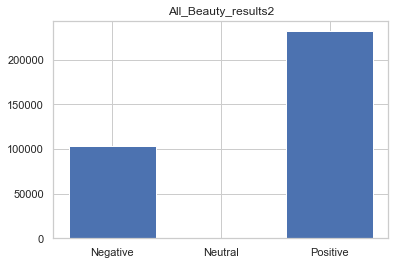

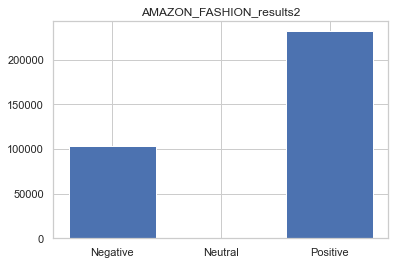

In [85]:
for result in df_results:
    y = df_results.T['class_counts'][0]
    plt.bar(cut_class_text, y)
    plt.title(result)
    plt.show()

In [86]:
df

,category_id,overall,star_sentiment,reviewText,summary,num_words,polarity,class,class_text
176525,1,1,0,Small,,1,-0.996106,0,Negative
176526,1,3,1,It's an elastic waistband with vertical strips...,"It's just ok. There is no ""tie top"" or split.",22,-0.852520,0,Negative
176527,1,5,2,"I purchased size large. I am 5'10"" with a 32""...","The length was perfect, just down to my ankles",75,0.999314,2,Positive
176528,1,5,2,Love that it is long and flowy. You can wear i...,Love that it is long and flowy,21,0.999852,2,Positive
176529,1,1,0,Hate it!! It is not as big and full. Like the...,,16,-0.999822,0,Negative
176530,1,1,0,It's a beautiful skirt but is way small. I got...,skirt not worth the money,46,-0.998091,0,Negative
176531,1,5,2,Looks like it cost more than I spent. It mana...,Absolutely beautiful and stunning little eveni...,52,-0.994881,0,Negative
176532,1,5,2,Perfect size - Beautiful purse that I used for...,Great value,21,0.999833,2,Positive
176533,1,5,2,The bag is stunning. Two separate straps for c...,The Glamourous Peacock,37,0.999731,2,Positive
176534,1,5,2,OMG! I love this purse! I was a little worri...,Perfect!,45,0.999717,2,Positive


## Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train, test = train_test_split(df["reviewText"], test_size=0.2, random_state=42, shuffle=True)

## Save reviews to text format

In [8]:
save_dir = "data/amazon"

train_file = "Prime_Pantry.reviewText.train.txt"
test_file = "Prime_Pantry.reviewText.test.txt"

train_path = os.path.join(save_dir, train_file)
test_path = os.path.join(save_dir, test_file)

train.to_csv(train_path, header=None, index=None, sep=' ')
test.to_csv(test_path, header=None, index=None, sep=' ')

# Pipeline

In [9]:
from transformers import pipeline

In [10]:
classifier = pipeline('sentiment-analysis')

In [92]:
df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote
0,1.0,False,"12 11, 2015",A27BTSGLXK2C5K,B017O9P72A,Jacob M. Wessler,Alexa is not able to control my lights. If I a...,"VERY Buggy, doesn't work.",1449792000,
1,4.0,False,"12 8, 2015",A27ZJ1NCBFP1HZ,B017O9P72A,Greg,"Alexa works great for me so far, but I'm also ...",So Far So Good,1449532800,5
2,1.0,False,"12 7, 2015",ACCQIOZMFN4UK,B017O9P72A,Da-Gr8-1,Weak!!\n\nAlexa doesn't even recognize the nam...,Time waster,1449446400,11
3,2.0,False,"12 5, 2015",A3KUPJ396OQF78,B017O9P72A,Larry Russlin,Can only control one of two bulbs from one of ...,Buggy,1449273600,
4,1.0,False,"02 2, 2018",A1U1RE1ZI19E1H,B017O9P72A,Rebekah,this worked great then randomly stopped. pleas...,stopped working,1517529600,2
...,...,...,...,...,...,...,...,...,...,...
996,5.0,False,"07 6, 2017",A2Q47Z4IJPFZRW,B017OBSCOS,Jim Conrad,Although Alexa doesn't always get the right wo...,Wonderful wordsmith game,1499299200,
997,5.0,False,"07 5, 2017",A2UUS1TBJFXV2L,B017OBSCOS,Nick DeTroia,"Great game, helps with expanding vocabulary an...",Awesome game,1499212800,
998,4.0,False,"07 3, 2017",A3G90J2GEGDVFC,B017OBSCOS,Akshaya Janardhanan,Keeps everyone entertained. A few times it doe...,Fun app,1499040000,
999,2.0,False,"07 3, 2017",A2JJF4WXHFBRIT,B017OBSCOS,Condo King,Needs work. Fun when it does work.,Gets alot of the words I say wrong. I repeat o...,1499040000,


In [45]:
df[['reviewText','summary', 'overall']][:10]

,reviewText,summary,overall
0,Alexa is not able to control my lights. If I a...,"VERY Buggy, doesn't work.",1.0
1,"Alexa works great for me so far, but I'm also ...",So Far So Good,4.0
2,Weak!!\n\nAlexa doesn't even recognize the nam...,Time waster,1.0
3,Can only control one of two bulbs from one of ...,Buggy,2.0
4,this worked great then randomly stopped. pleas...,stopped working,1.0
5,Great skill,Great,5.0
6,Pretty crappy. Won&rsquo;t connect with Alexis,Returning to,1.0
7,Not happy. Can not connect to Alexa regardless.,Can not connect to ECHO,1.0
8,Can not connect a hue lights to Alexa. Linked ...,Connecting is a no go,1.0
9,"The service works with google home, but doesn'...",Does not work,1.0


In [56]:
df['summary'] + '. ' + df['reviewText']

0       VERY Buggy, doesn't work.. Alexa is not able t...
1       So Far So Good. Alexa works great for me so fa...
2       Time waster. Weak!!\n\nAlexa doesn't even reco...
3       Buggy. Can only control one of two bulbs from ...
4       stopped working. this worked great then random...
                              ...                        
996     Wonderful wordsmith game. Although Alexa doesn...
997     Awesome game. Great game, helps with expanding...
998     Fun app. Keeps everyone entertained. A few tim...
999     Gets alot of the words I say wrong. I repeat o...
1000    Poor diction. G, y, d, and n/m words won't pic...
Length: 1001, dtype: object

In [63]:
inputs = list(df['reviewText'] + '. ' + df['summary'])[:10]

In [64]:
inputs[1]

'Alexa works great for me so far, but I\'m also only controlling a single bulb at the moment. Turning on/off, changing colors and adjusting brightness are all easy and quick. That being said, I\'m expecting complications as I add more bulbs (hope for the best prepare for the worst, right?)\n\nI\'d speculate that some other users\' frustrations might stem from Alexa not recognizing their bulb or room names. After simplifying my bulb name to \'Lamp\' and listing it under a Living Room group (within the LIFx app), I\'ve been able to address it by either category pretty consistently.\n"Turn on/off living room lights."\n"Change lamp light to [color]"\n"Dim living room lights to [X]%"\n\nLike any new tech, you can expect growing pains and bugs early on. Be patient. This skill isn\'t perfect by any means, but I\'d say it\'s off to a decent start. So Far So Good'

In [65]:
sentiments = classifier(inputs)

In [66]:
# for sentence, sentiment in zip(inputs, sentiments):
#     print(f"{'+' if sentiment['label'] == 'POSITIVE' else '-'} {round(sentiment['score'], 4)}: {sentence} ")

In [67]:
df_results = pd.DataFrame(sentiments)
df_results['sentiment'] = np.where(df_results['label'] == 'POSITIVE', df_results['score'], -1.0 * df_results['score'])

cut_class = np.arange(1,6) # mimics stars, but really should be np.arange(5)
cut_class_text = ["Terrible", "Negative", "Neutral", "Positive", "Excellent"]
cut_bins = np.linspace(
    start = -1, 
    stop = 1,
    num = 6
)
cut_intervals = pd.interval_range(
    start = -1, 
    end = 1,
    periods = 5
)

df_results['interval']   = pd.cut(df_results['sentiment'], bins=cut_intervals)
df_results['class']      = pd.cut(df_results['sentiment'], bins=cut_bins, labels=cut_class)
df_results['class_text'] = pd.cut(df_results['sentiment'], bins=cut_bins, labels=cut_class_text)

In [68]:
df_results

,label,score,sentiment,interval,class,class_text
0,NEGATIVE,0.999785,-0.999785,"(-1.0, -0.6]",1,Terrible
1,POSITIVE,0.939940,0.939940,"(0.6000000000000001, 1.0]",5,Excellent
2,NEGATIVE,0.999819,-0.999819,"(-1.0, -0.6]",1,Terrible
3,NEGATIVE,0.999513,-0.999513,"(-1.0, -0.6]",1,Terrible
4,NEGATIVE,0.998790,-0.998790,"(-1.0, -0.6]",1,Terrible
5,POSITIVE,0.999876,0.999876,"(0.6000000000000001, 1.0]",5,Excellent
6,NEGATIVE,0.999337,-0.999337,"(-1.0, -0.6]",1,Terrible
7,NEGATIVE,0.999773,-0.999773,"(-1.0, -0.6]",1,Terrible
8,NEGATIVE,0.999263,-0.999263,"(-1.0, -0.6]",1,Terrible
9,NEGATIVE,0.999730,-0.999730,"(-1.0, -0.6]",1,Terrible


In [25]:
df_results['class'].value_counts(sort=False)

1    9
2    0
3    0
4    0
5    1
Name: class, dtype: int64

# Tokenizer + Model

In [151]:
import torch
from transformers import AutoModel, AutoTokenizer, BertTokenizer

In [152]:
# Store the model we want to use
MODEL_NAME = "distilbert-base-uncased"

# We need to create the model and tokenizer
model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [158]:
tokenizer